# $x^2$ potential

In [1]:
import pickle
import numpy as np
import pycuda.gpuarray as gpuarray
from scipy.special import hyp1f1
import scipy.fftpack as fftpack
import pylab as plt
import time

#-------------------------------------------------------------------------------------
from pywignercuda_path import SetPyWignerCUDA_Path
SetPyWignerCUDA_Path()
from GPU_Wigner2D_GPitaevskii import *

In [2]:
%matplotlib inline

## Settings

In [3]:
class frame( GPU_Wigner2D_GPitaevskii_Bloch ):
    def __init__ (self):
        X_gridDIM = 512
        P_gridDIM = 512
        
        X_amplitude  = 12
        P_amplitude  = 12
        
        hBar = 1.
        dt= 0.01
        
        timeSteps =    800
        skipFrames =   100
        
        mass = 1.      
                
        #Gross Pitaevskii coefficient
        self.GPitaevskiiCoeff = 1.
        
        # Potential and derivative of potential
        self.omega = 1.
        X2_constant = 0.5*mass*self.omega**2
        
        kinematicString  = '0.5*p*p/{mass}'.format(mass=mass)
        potentialString  = '{0}*pow(x,2) + 0.05*pow(x,4)'.format(X2_constant)

        dPotentialString = '2*{0}*x + 0.2*pow(x,3)'.format(X2_constant)
        
        self.SetTimeTrack( dt, timeSteps, skipFrames,
        fileName = '/home/rcabrera/DATA/Wigner2D_GPitaevskii/X4_Ground.hdf5' )
        
        GPU_Wigner2D_GPitaevskii_Bloch.__init__(self,
            X_gridDIM,P_gridDIM,X_amplitude,P_amplitude,hBar,mass,potentialString,kinematicString)
    
    
    def Set_Initial_Condition(self):
        """
        """
        self.W_init = np.exp( -self.X**2/30. - self.P**2/30.  )
        
        norm =  np.sum(self.W_init)*self.dX*self.dP
        
        self.W_init /= norm

## Run

In [4]:
instance = frame()
print '							'
print ' 	Wigner2D propagator with damping	'
print '							'

instance.Set_Initial_Condition ()

%time instance.Run( )

							
 	Wigner2D propagator with damping	
							
 X_gridDIM =  512    P_gridDIM =  512
 dx =  0.046875  dp =  0.046875
 dLambda =  0.261799387799  dTheta =  0.261799387799
  
         GPU memory Total        5.24945068359 GB
         GPU memory Free         4.49657058716 GB
Initial W Norm =  (1+0j)
         GPU memory Free  post gpu loading  4.48485183716 GB
 ------------------------------------------------------------------------------- 
     Split Operator Propagator  GPU with damping                                 
 ------------------------------------------------------------------------------- 
        
        
step  0
step  100
step  200
step  300
step  400
step  500
step  600
step  700
step  800
CPU times: user 6.68 s, sys: 4.08 s, total: 10.8 s
Wall time: 11.9 s


0

## Plots

Potential


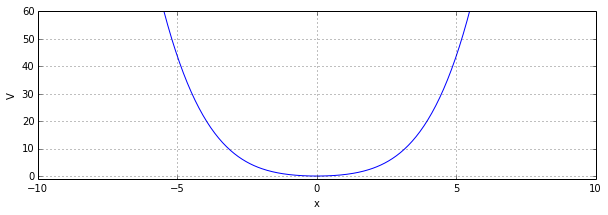

In [5]:
print 'Potential'
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot( instance.X_range,   instance.Potential(0,instance.X_range) )
ax.set_xlim(-10,10)
ax.set_ylim(-1,60)
ax.set_xlabel('x')
ax.set_ylabel('V')
ax.grid('on')

In [6]:
def PlotWignerFrame( W_input , x_plotRange,p_plotRange):
    W = W_input.copy()
    W = fftpack.fftshift(W.real)    
    
    dp    = instance.dP
    p_min = -instance.P_amplitude
    p_max =  instance.P_amplitude - dp   
    
    #p_min = -dp*instance.P_gridDIM/2.
    #p_max =  dp*instance.P_gridDIM/2. - dp    
    
    x_min = -instance.X_amplitude
    x_max =  instance.X_amplitude - instance.dX
    
    global_max = 0.17          #  Maximum value used to select the color range
    global_min = -0.31         # 
        
    print 'min = ', np.min( W ), ' max = ', np.max( W )
    print 'final time =', instance.timeRange[-1] ,'a.u.  =',\
    instance.timeRange[-1]*( 2.418884326505*10.**(-17) ) , ' s '
    
    print 'normalization = ', np.sum( W )*instance.dX*dp

    zero_position =  abs( global_min) / (abs( global_max) + abs(global_min)) 
    wigner_cdict = {'red' 	: 	((0., 0., 0.),
							(zero_position, 1., 1.), 
							(1., 1., 1.)),
					'green' :	((0., 0., 0.),
							(zero_position, 1., 1.),
							(1., 0., 0.)),
					'blue'	:	((0., 1., 1.),
							(zero_position, 1., 1.),
							(1., 0., 0.)) }
    wigner_cmap = matplotlib.colors.LinearSegmentedColormap('wigner_colormap', wigner_cdict, 256)

    fig, ax = plt.subplots(figsize=(12, 5))

    cax = ax.imshow( W ,origin='lower',interpolation='none',\
    extent=[ x_min , x_max, p_min, p_max], vmin= global_min, vmax=global_max, cmap=wigner_cmap)

    ax.contour(instance.Hamiltonian ,
                np.arange(0, 40, 3 ),origin='lower',extent=[x_min,x_max,p_min,p_max],
               linewidths=0.25,colors='k')
    
    axis_font = {'size':'24'}
    
    ax.set_xlabel(r'$x$',**axis_font)
    ax.set_ylabel(r'$p$',**axis_font)
    
    ax.set_xlim((x_plotRange[0] , x_plotRange[1] ))
    ax.set_ylim((p_plotRange[0] , p_plotRange[1] ))
    ax.set_aspect(1.)
    #ax.grid('on')
    cbar = fig.colorbar(cax, ticks=[-0.3, -0.2,-0.1, 0, 0.1, 0.2 , 0.3])
    matplotlib.rcParams.update({'font.size': 18})
    return fig

min =  7.2142931611e-07  max =  0.0106517462674
final time = 8.0 a.u.  = 1.9351074612e-16  s 
normalization =  1.0


/usr/lib/pymodules/python2.7/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


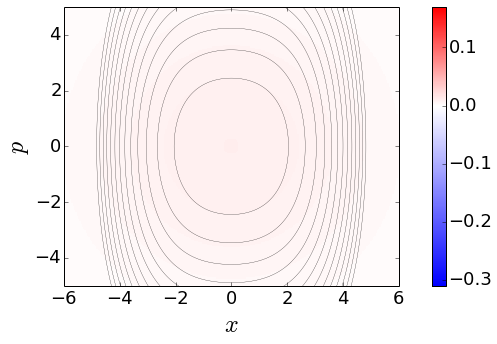

In [7]:
plot_init = PlotWignerFrame( instance.W_init.real , (-6.,6) ,(-5,5)  )


min =  -0.00137714664934  max =  0.318066263757
final time = 8.0 a.u.  = 1.9351074612e-16  s 
normalization =  1.0


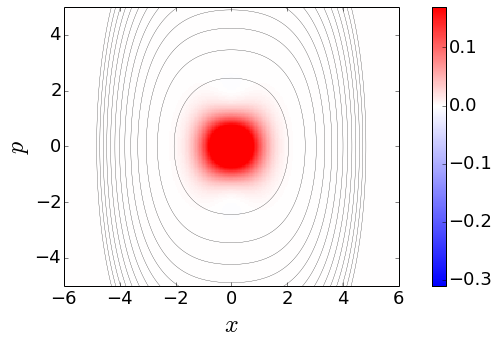

In [8]:
plot_init = PlotWignerFrame( instance.W_0 , (-6.,6) ,(-5,5)  )

In [9]:
def PlotMarginals():
    
    W = fftpack.fftshift( instance.W_0 )
    
    dp    = instance.dP
    p_min = -instance.P_amplitude
    p_max =  instance.P_amplitude - dp   
        
    W0 = fftpack.fftshift(instance.W_init  )
    
    marginal_x_init = np.sum(  W0 , axis=0 )*dp
    marginal_p_init = np.sum(  W0 , axis=1 )*instance.dX

    marginal_x = np.sum(  W, axis=0 )*dp
    marginal_p = np.sum(  W, axis=1 )*instance.dX


    x_min = -instance.X_amplitude
    x_max = instance.X_amplitude - instance.dX 
    #.......................................... Marginal in position

    plt.figure(figsize=(10,10))
    plt.subplot(211)
   
    plt.plot(instance.X_range, marginal_x_init, '-',label='initial')
    plt.plot(instance.X_range, marginal_x,  label='final')
    plt.axis([x_min/2., x_max/2., -0.01,1])
    plt.xlabel('x')
    plt.ylabel('Prob')

    plt.legend(loc='upper right', shadow=True)

    #..........................................  Marginal in momentum

    print 'p = ', np.sum( marginal_p*instance.P_range )*dp,\
    '->', np.sum( W*instance.P )*instance.dX*dp
    print 'x = ', np.sum( W0*instance.X )*instance.dX*dp, \
    '->',np.sum( W*instance.X )*instance.dX*dp
    
    rangeP = np.linspace( p_min, p_max, instance.P_gridDIM )
    
    plt.subplot(212)
    plt.plot(rangeP, marginal_p_init ,'-', label='initial')
    plt.plot(rangeP, marginal_p  , label='final')
    plt.axis([p_min, p_max, -0.01, 1])
    plt.xlabel('p')
    plt.ylabel('Prob')

    plt.legend(loc='upper right', shadow=True)

p =  -9.03443986289e-15 -> -0.316165420301
x =  -0.0580541048713 -> -0.298688345707


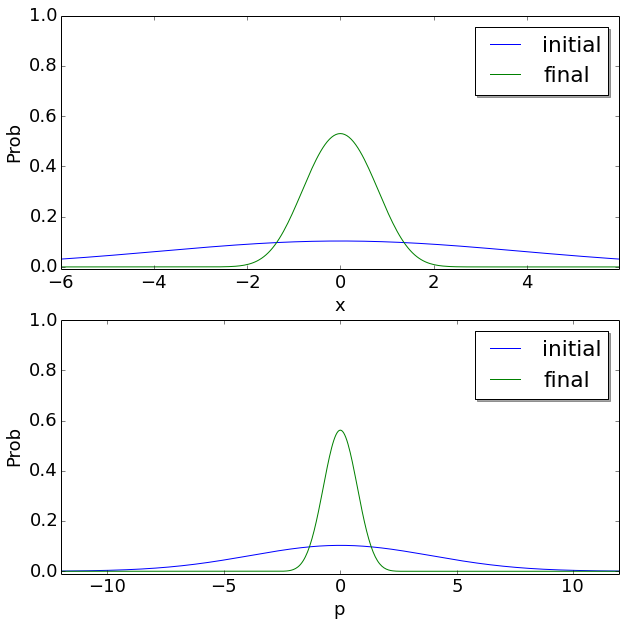

In [10]:
PlotMarginals()

In [11]:
def PlotMarginal_x(W_init_ , W_end_):
    fig, ax = plt.subplots(figsize=(15, 5))

    #
    W_end  = fftpack.fftshift( W_end_.real )
    W_init = fftpack.fftshift( W_init_.real  )

    dx    = instance.dX
    dp    = instance.dP
    p_min = -instance.P_amplitude
    p_max =  instance.P_amplitude - dp   

    x_min = -instance.X_amplitude
    x_max =  instance.X_amplitude - dx   

    marginal_x_init =  instance.WignerMarginal_Probability_x(W_init)
    marginal_x_end  =  instance.WignerMarginal_Probability_x(W_end)

    # Potential
    ax.fill_between( instance.X_range, instance.Potential(0,instance.X_range)/4. , color='lightgray' )

    # Marginal x

    ax.plot(instance.X_range , marginal_x_init,
            '-',label='initial', linewidth=2.)

    ax.plot(instance.X_range , marginal_x_end,
            label='final', linewidth=2., color = 'red') 
    
    ax.set_xlim( -instance.X_amplitude/4 , instance.X_amplitude/4. )
    ax.set_ylim(-0.01 , 1. )
    ax.set_aspect(4.)
    axis_font = {'size':'24'}
    ax.set_xlabel('$ x (a.u.)$', **axis_font  )
    ax.set_ylabel('$ V (a.u.)$', **axis_font  )
    ax.grid('on')

    ax.legend(loc='upper right', shadow=True)

In [12]:
def PlotMarginal_p(W_init_ , W_end_):
    fig, ax = plt.subplots(figsize=(15, 5))

    #
    W_end  = fftpack.fftshift( W_end_.real )
    W_init = fftpack.fftshift( W_init_.real  )

    dx    = instance.dX
    dp    = instance.dP
    p_min = -instance.P_amplitude
    p_max =  instance.P_amplitude - dp   

    x_min = -instance.X_amplitude
    x_max =  instance.X_amplitude - dx   

    marginal_p_init =  instance.WignerMarginal_Probability_p(W_init)
    marginal_p_end  =  instance.WignerMarginal_Probability_p(W_end)

    # Marginal p

    ax.plot(instance.P_range , marginal_p_init,
            '-',label='initial', linewidth=2.)

    ax.plot(instance.P_range , marginal_p_end,
            label='final', linewidth=2., color = 'red') 
    
    ax.set_xlim( -instance.P_amplitude/4 , instance.P_amplitude/4. )
    ax.set_ylim(-0.01 , 1. )
    ax.set_aspect(4.)
    axis_font = {'size':'24'}
    ax.set_xlabel('$ x (a.u.)$', **axis_font  )
    ax.set_ylabel('$ V (a.u.)$', **axis_font  )
    ax.grid('on')

    ax.legend(loc='upper right', shadow=True)

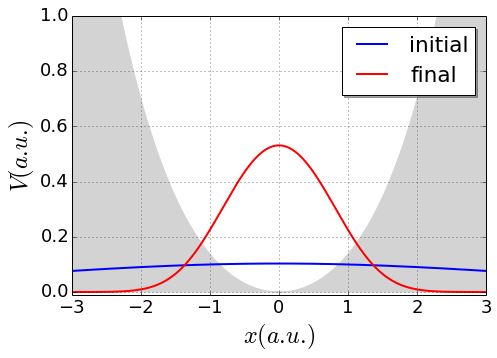

In [13]:
PlotMarginal_x( instance.W_init , instance.W_0 )

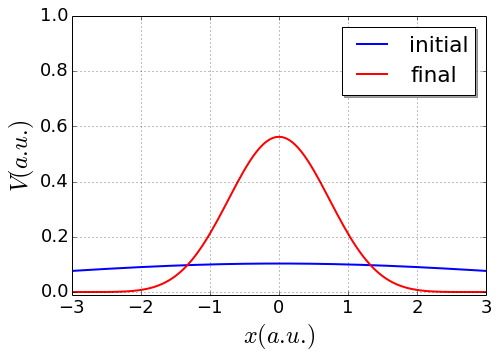

In [14]:
PlotMarginal_p( instance.W_init , instance.W_0 )

## First Order Ehrenfest

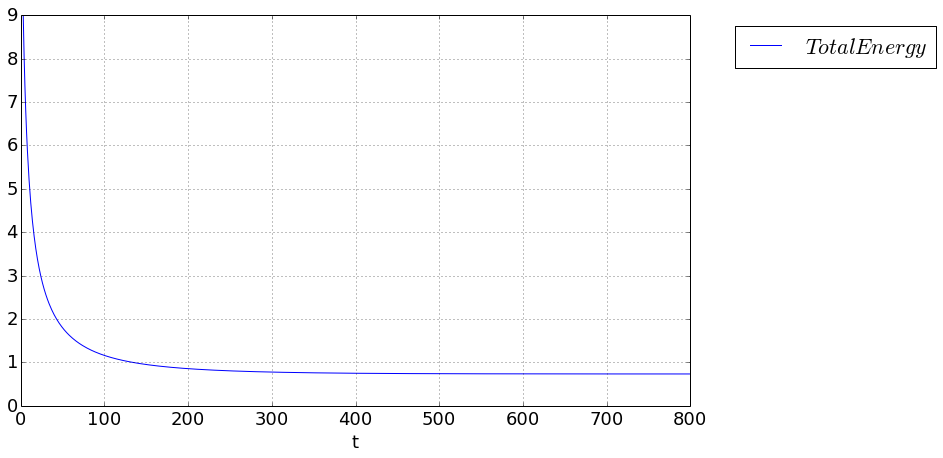

In [15]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot( instance.TotalEnergyHistory  ,
        '-' , label = '$Total Energy$' , linewidth=1.)



ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
ax.set_ylim( 0. , 9. )
ax.set_xlabel('t')
ax.set_ylabel(' ')
ax.grid();

In [16]:
instance.NonLinearEnergyHistory.shape

(800,)

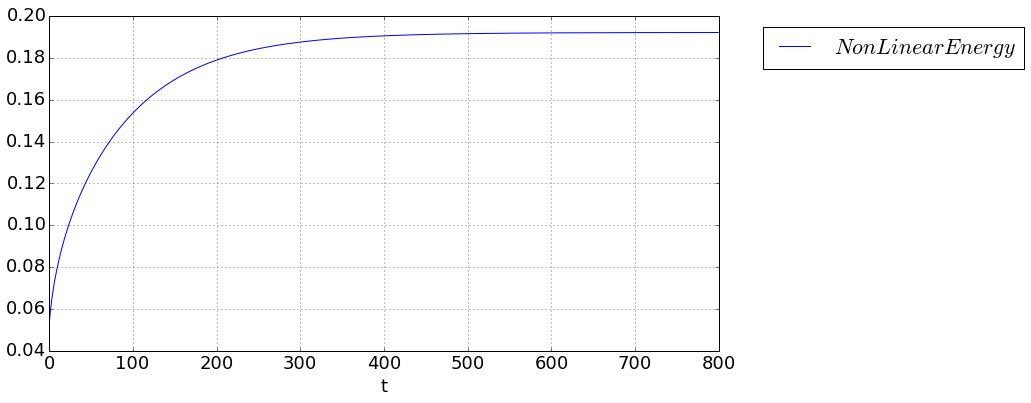

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(  instance.NonLinearEnergyHistory
        , '-' , label = '$Non Linear Energy$' , linewidth=1.)


ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
#ax.set_ylim( 1.19 , 1.21 )
ax.set_xlabel('t')
ax.set_ylabel(' ')
ax.grid();

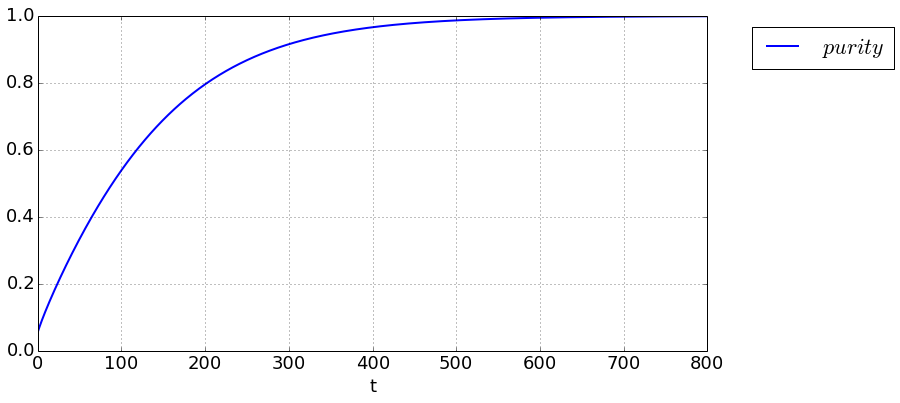

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(  instance.purity , '-' , label = '$purity $',linewidth=2.)


ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
#ax.set_ylim( 0.99 , 1.01 )
ax.set_xlabel('t')
ax.set_ylabel(' ')
ax.grid();

## First Exited state

In [19]:
%time instance.Run_ExitedState1( timeSteps=600 )

         GPU memory Total        5.24945068359 GB
         GPU memory Free         4.49266433716 GB
Initial W Norm =  (1+0j)
         GPU memory Free  post gpu loading  4.47703933716 GB
 ------------------------------------------------------------------------------- 
     Split Operator Propagator  GPU with damping                                 
 ------------------------------------------------------------------------------- 
        
        
step  0
step  100
dt =  0.01
dt =  0.005
dt =  0.0025
dt =  0.00125
dt =  0.000625
dt =  0.0003125
dt =  0.00015625
dt =  7.8125e-05
dt =  3.90625e-05
dt =  1.953125e-05
dt =  9.765625e-06
dt =  4.8828125e-06
dt =  2.44140625e-06
dt =  1.220703125e-06
dt =  6.103515625e-07
dt =  3.0517578125e-07
dt =  1.52587890625e-07
dt =  7.62939453125e-08
dt =  3.81469726563e-08
dt =  1.90734863281e-08
dt =  9.53674316406e-09
dt =  4.76837158203e-09
dt =  2.38418579102e-09
dt =  1.19209289551e-09
dt =  5.96046447754e-10
dt =  2.98023223877e-10
dt =  1.49011

0

min =  -0.216480171807  max =  0.129404530769
final time = 6.0 a.u.  = 1.4513305959e-16  s 
normalization =  1.0


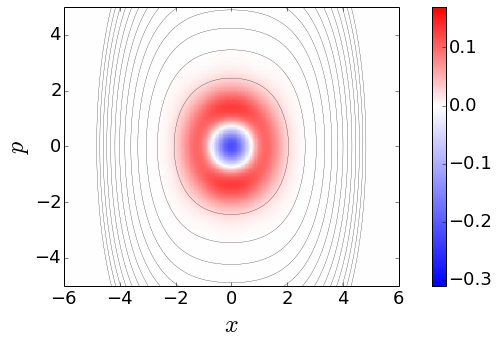

In [20]:
plot_init = PlotWignerFrame( instance.W_1 , (-6.,6) ,(-5,5)  )

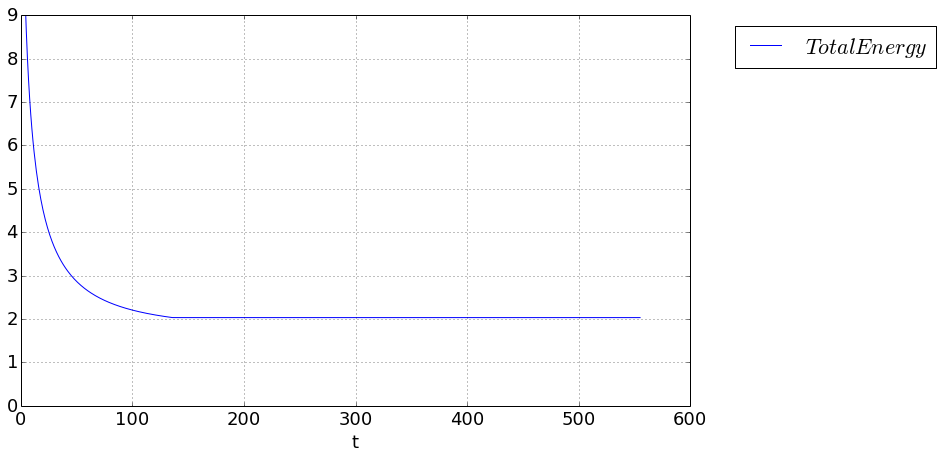

In [21]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot( instance.TotalEnergyHistory  ,
        '-' , label = '$Total Energy$' , linewidth=1.)



ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
ax.set_ylim( 0 , 9)
ax.set_xlabel('t')
ax.set_ylabel(' ')
ax.grid();

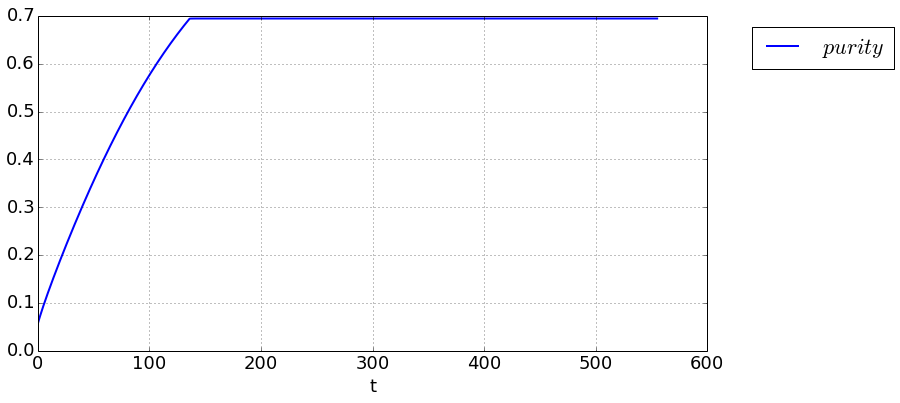

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(  instance.purity , '-' , label = '$purity $',linewidth=2.)


ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
#ax.set_ylim( 0.99 , 1.01 )
ax.set_xlabel('t')
ax.set_ylabel(' ')
ax.grid();

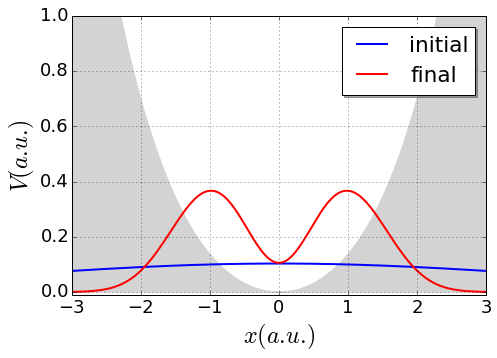

In [23]:
PlotMarginal_x( instance.W_init , instance.W_1 )

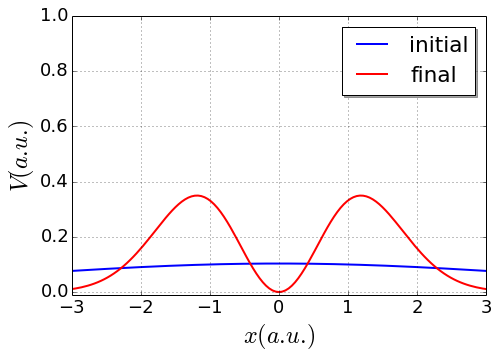

In [24]:
PlotMarginal_p( instance.W_init , instance.W_1 )